# Overview / Thesis of the plot
* Claim to make:
    * Plot 1: x = n_par_region (8,16,32,64,128), y = (normalized compute util, flops allocated, on-chip-req)
        * In memory bound cases, timesharing can achieve similar performance with less compute and on-chip memory resource due to high utilization
    * Plot 2: x = n_par_region (all), y = (cycles, utilization)
        * Insight: However, allocating too little parallel region can cause worse compute utilization as the HBM bw utilization reduces due to the small parallelization factor in the memory bound application. Furthermore, when gathering expert weights per expert to do the computation as a gemm for better data reuse, making increasingly many experts share the same region (i.e., very small parallelization factor) can cause a high fan-out.

# Plot creation

## Plot 1: Timesharing increases utilization

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def timeshare_utilization(csv_file, output_file=None, utilization_scale=None, on_chip_scale=None, allocated_flops_scale=None):
    """
    Create a multi-axis line chart from a single CSV file.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_file (str, optional): Path to save the plot
    utilization_scale (tuple, optional): Y-axis scale for utilization
    on_chip_scale (tuple, optional): Y-axis scale for on-chip requirement
    allocated_flops_scale (tuple, optional): Y-axis scale for allocated FLOPS
    """
    axis_font = 40
    legend_font = 28
    tick_font = 32
    x_tick_size = 32
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].astype(str).tolist()
    
    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(11, 10))
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    baseline_utilization = df_combined['utilization(%)'].iloc[0]

    ax1.set_xlabel('Parallel Experts', fontsize=axis_font, fontweight='bold')
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, df_combined['utilization(%)']/baseline_utilization, 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (normalized)')
    
    # Customize first y-axis (for utilization)
    # ax1.set_ylabel('Compute Utilization', fontsize=axis_font, fontweight='bold', color=color_palette[0])
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    # Remove scientific notation formatting for percentage values
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for on_chip_requirement_bytes
    ax2 = ax1.twinx()
    line2 = ax2.plot(x_pos, df_combined['on_chip_requirement_bytes'] / 1000, 
                     color=color_palette[2], marker='s', linewidth=3, 
                     markersize=8, label='On-Chip Requirement (KB)')
    
    # Customize second y-axis (for on-chip requirement)
    # ax2.set_ylabel('On-Chip Memory (KB)', fontsize=axis_font, fontweight='bold', color=color_palette[2])
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.89, 1.02))  # (x, y) in axis coordinates
    
    
    # Create third y-axis for allocated_flops
    ax3 = ax1.twinx()
    # Offset the third axis
    ax3.spines['right'].set_position(('outward', 75))
    
    # Create line plot for allocated_flops
    line = ax3.plot(x_pos, df_combined['allocated_flops'], 
                    color=color_palette[4], marker='^', linewidth=3, 
                    markersize=8, label=f'Allocated Comp. Resource \n(FLOPs/cycle)')
    
    
    # Customize third y-axis
    # ax3.set_ylabel('Allocated Compute (FLOPs/cycle)', fontsize=axis_font, fontweight='bold', color=color_palette[4])
    ax3.tick_params(axis='y', labelcolor=color_palette[4], labelsize=tick_font)
    ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax3_offset_text = ax3.yaxis.get_offset_text()
    ax3_offset_text.set_fontsize(tick_font)
    ax3_offset_text.set_position((1, 1.02))  # (x, y) in axis coordinates
    
    
    # ==================== Set Range ====================
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale) # utilization
    if on_chip_scale is not None:
        ax2.set_ylim(on_chip_scale) # on-chip requirement
    if allocated_flops_scale is not None:
        ax3.set_ylim(allocated_flops_scale) # allocated flops
    

        
    # Add value labels to line points
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['utilization(%)'])):
    #     ax1.annotate(f'{y:.1f}%',
    #         xy=(x, y),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[0], fontweight='bold')
    
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['on_chip_requirement_bytes'])):
    #     ax2.annotate(f'{y/1000:,.0f}',
    #         xy=(x, y/1000),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[2], fontweight='bold')
    
    # for i, (x, y) in enumerate(zip(x_pos, df_combined['allocated_flops'])):
    #     ax3.annotate(f'{y:,.0f}',
    #         xy=(x, y),
    #         xytext=(0, 10),
    #         textcoords="offset points",
    #         ha='center', va='bottom',
    #         fontsize=8, color=color_palette[4], fontweight='bold')
    
    
    # Combine legends from all axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2 + lines3
    all_labels = labels1 + labels2 + labels3
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add title and grid
    # plt.title('Memory Traffic and Cycles Analysis', fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

Plot saved to /home/ginasohn/step_tl/timeshare_mem_bound/qwen_128_96_iter032_layer_012_n32_f48_timeshare_membound.pdf


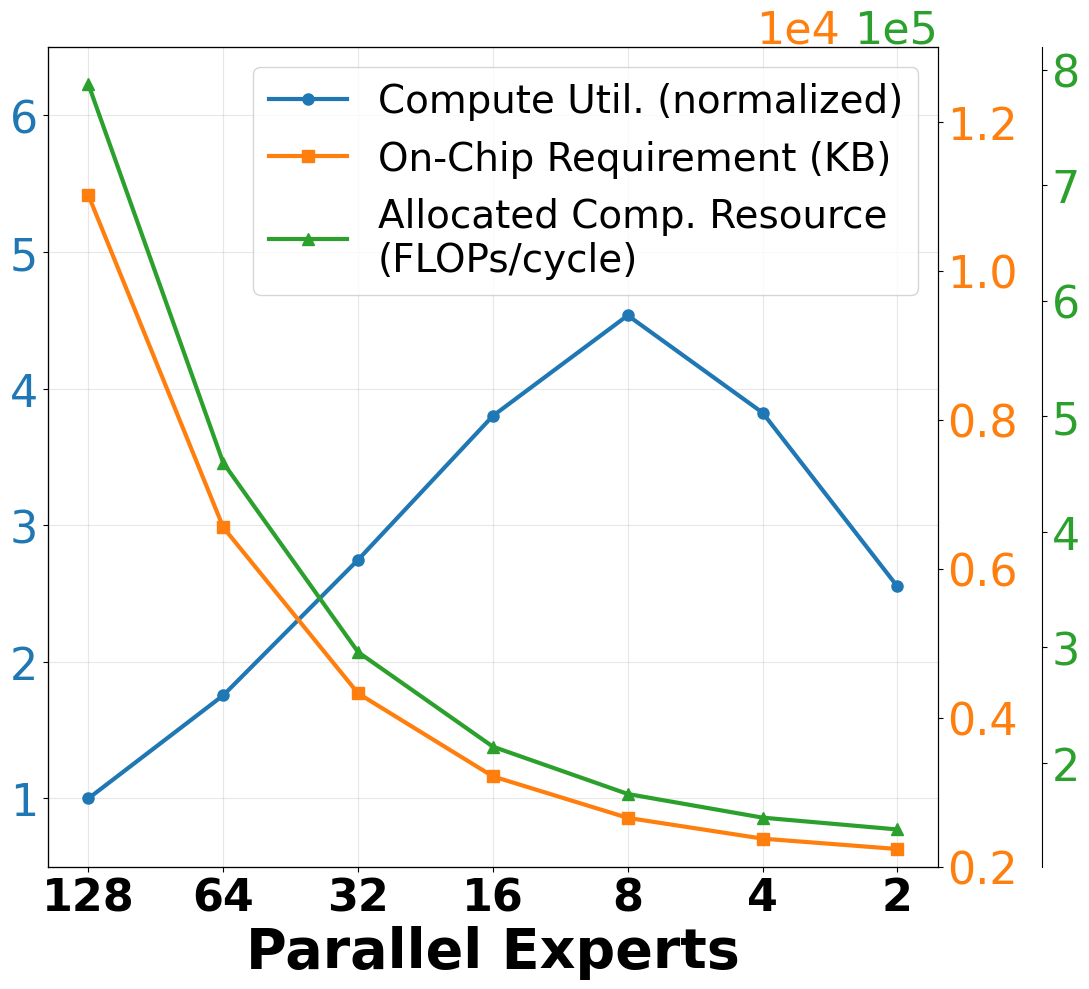

In [62]:
csv_file = "/home/ginasohn/step_tl/timeshare_mem_bound/combined_qwen_128_96_iter032_layer_012_n32_f48_timeshare_membound.csv"
output_file = "/home/ginasohn/step_tl/timeshare_mem_bound/qwen_128_96_iter032_layer_012_n32_f48_timeshare_membound.pdf"
# output_file = None

utilization_scale = None
on_chip_scale = None
allocated_flops_scale = None

utilization_scale = (0.5,6.5) # off-chip traffic
on_chip_scale = (0.2*1e4,1.3*1e4) # on-chip requirement
# allocated_flops_scale = (0,4*1e6) # cycles

timeshare_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, on_chip_scale=on_chip_scale, allocated_flops_scale=allocated_flops_scale)

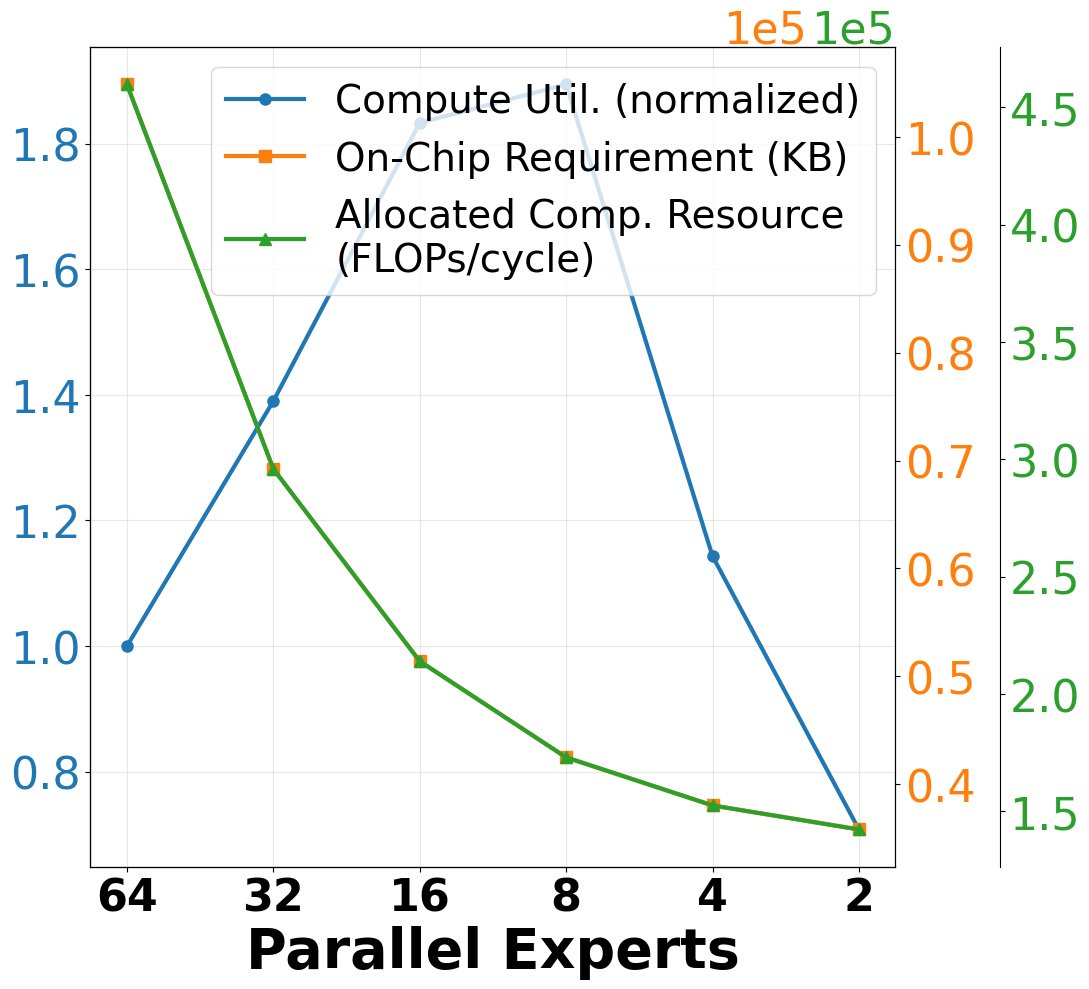

In [63]:
csv_file = "/home/ginasohn/step_tl/timeshare_mem_bound/combined_qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.csv"
output_file = "/home/ginasohn/step_tl/timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.pdf"
output_file = None

utilization_scale = None
on_chip_scale = None
allocated_flops_scale = None

# utilization_scale = (0.5,6.5) # off-chip traffic
# on_chip_scale = (0.2*1e4,1.3*1e4) # on-chip requirement
# allocated_flops_scale = (0,4*1e6) # cycles

timeshare_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, on_chip_scale=on_chip_scale, allocated_flops_scale=allocated_flops_scale)

## Plot 2: Finding the right expert sharing degree is important

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

def cycle_utilization(csv_file, output_file=None, utilization_scale=None, cycles_scale=None):
    """
    Create a multi-axis line chart from a single CSV file.
    
    Parameters:
    csv_file (str): Path to CSV file
    output_file (str, optional): Path to save the plot
    utilization_scale (tuple, optional): Y-axis scale for utilization
    cycles_scale (tuple, optional): Y-axis scale for cycles
    """
    axis_font = 40
    legend_font = 28
    tick_font = 32
    x_tick_size = 32
    
    # Set up color palette
    color_palette = sns.color_palette(palette='tab20')
    
    # Read CSV file
    df_combined = pd.read_csv(csv_file)
    
    # Create display names from n_par_region column
    display_names = df_combined['n_par_region'].astype(str).tolist()
    
    # Set up the plot with multiple y-axes
    fig, ax1 = plt.subplots(figsize=(11, 10))
    
    # Position of points on X axis
    x_pos = np.arange(len(display_names))
    
    baseline_utilization = df_combined['utilization(%)'].iloc[0]

    ax1.set_xlabel('Parallel Experts', fontsize=axis_font, fontweight='bold')
    
    # Create first y-axis for utilization
    line1 = ax1.plot(x_pos, df_combined['utilization(%)']/baseline_utilization, 
                     color=color_palette[0], marker='o', linewidth=3, 
                     markersize=8, label=f'Compute Util. (normalized)')
    
    # Customize first y-axis (for utilization)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(display_names, ha='center', fontsize=x_tick_size, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_palette[0], labelsize=tick_font)
    
    # Create second y-axis for cycles
    ax2 = ax1.twinx()
    line2 = ax2.plot(x_pos, df_combined['cycles'], 
                     color=color_palette[2], marker='s', linewidth=3, 
                     markersize=8, label='Cycles')
    
    # Customize second y-axis (for cycles)
    ax2.tick_params(axis='y', labelcolor=color_palette[2], labelsize=tick_font)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    ax2_offset_text = ax2.yaxis.get_offset_text()
    ax2_offset_text.set_fontsize(tick_font)
    ax2_offset_text.set_position((0.99, 1.02))  # (x, y) in axis coordinates
    
    # ==================== Set Range ====================
    if utilization_scale is not None:
        ax1.set_ylim(utilization_scale) # utilization
    if cycles_scale is not None:
        ax2.set_ylim(cycles_scale) # cycles
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    # Create a single legend with all elements
    all_handles = lines1 + lines2
    all_labels = labels1 + labels2
    ax1.legend(all_handles, all_labels, loc='upper right', fontsize=legend_font)
    
    # Add grid
    ax1.grid(True, alpha=0.3)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save plot if output file specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {output_file}")
    
    # Show plot
    plt.show()

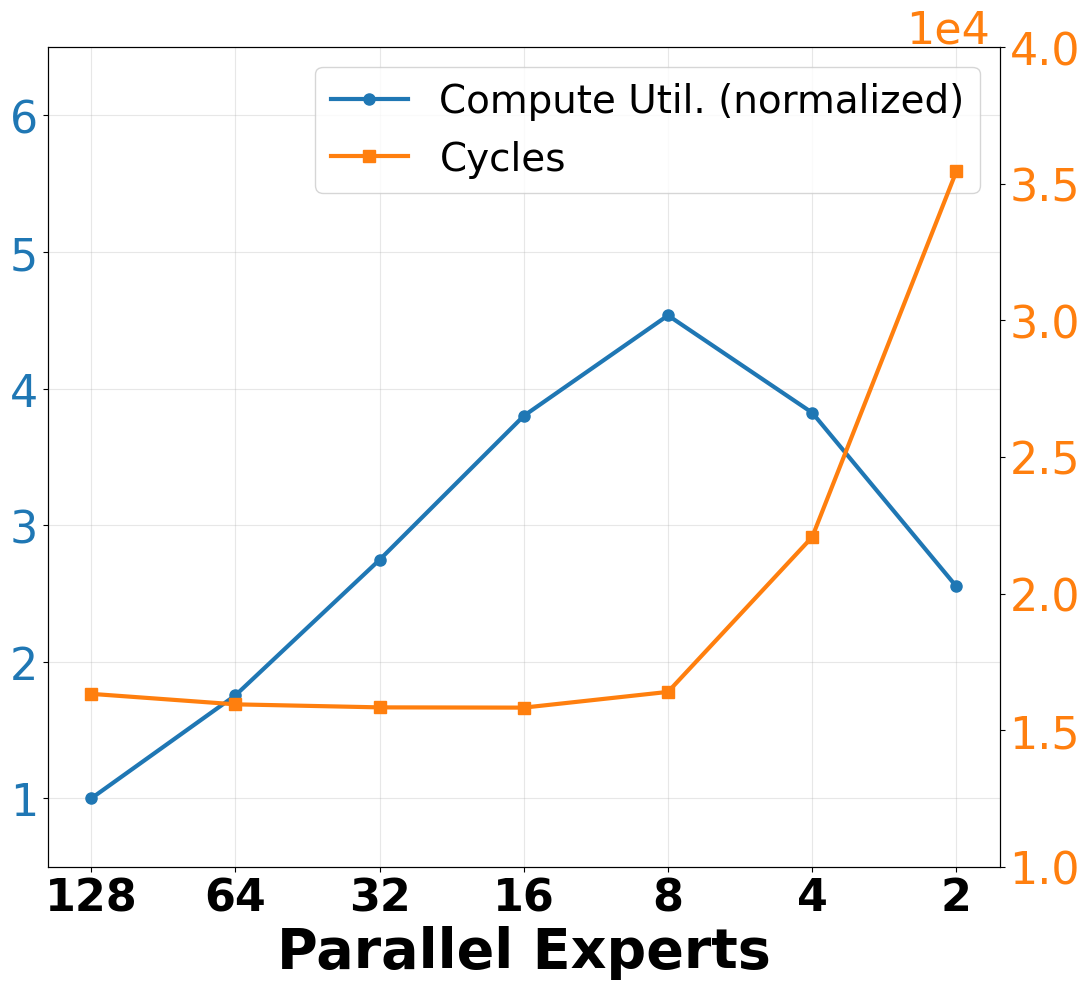

In [74]:
csv_file = "/home/ginasohn/step_tl/timeshare_mem_bound/combined_qwen_128_96_iter032_layer_012_n32_f48_timeshare_membound.csv"
output_file = "/home/ginasohn/step_tl/timeshare_mem_bound/qwen_128_96_iter032_layer_012_n32_f48_timeshare_membound.pdf"
output_file = None

utilization_scale = None
cycles_scale = None

utilization_scale = (0.5,6.5) # off-chip traffic
cycles_scale = (1*1e4,4*1e4) # cycles

cycle_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, cycles_scale=cycles_scale)

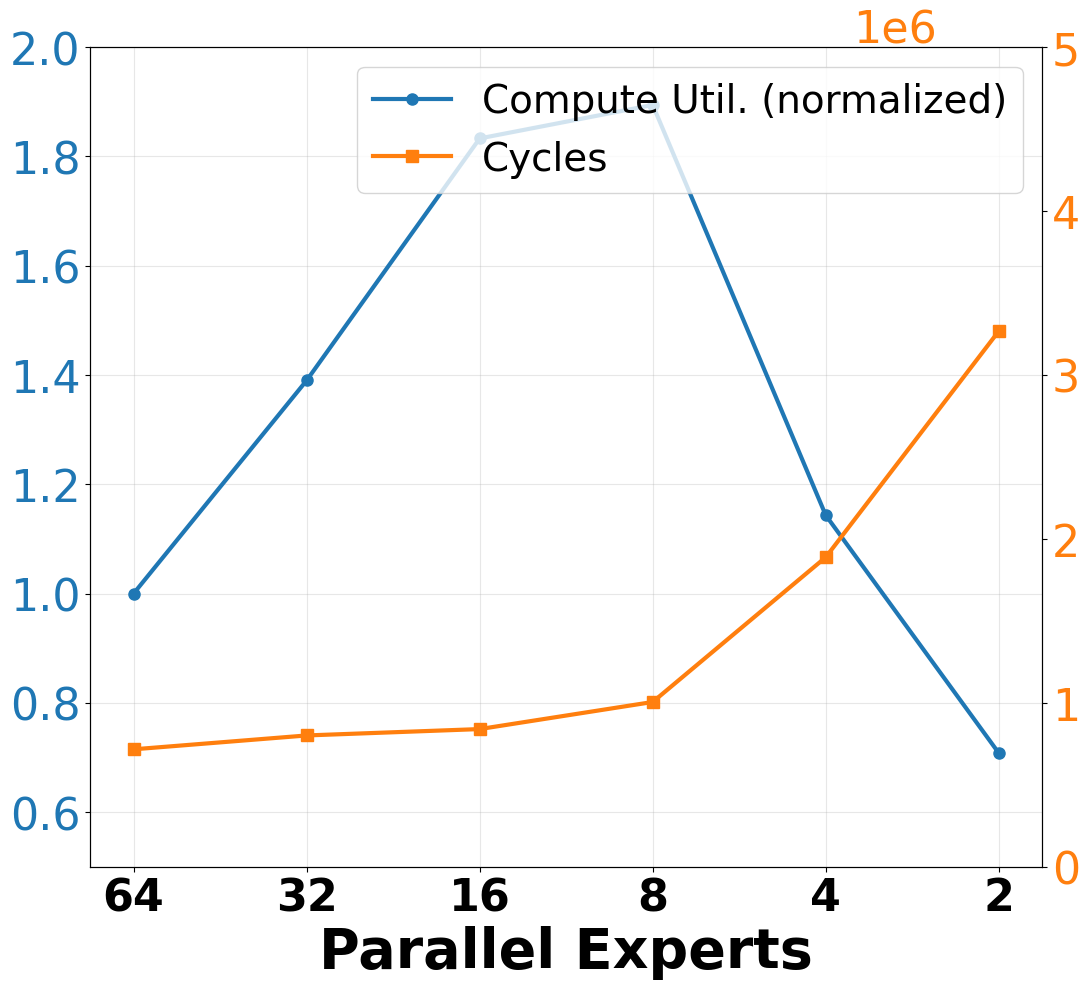

In [69]:
csv_file = "/home/ginasohn/step_tl/timeshare_mem_bound/combined_qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.csv"
output_file = "/home/ginasohn/step_tl/timeshare_mem_bound/qwen_2048_768_iter032_layer_012_n32_f48_timeshare_membound.pdf"
output_file = None

utilization_scale = None
cycles_scale = None

utilization_scale = (0.5,2) # util
cycles_scale = (0*1e6,5*1e6) # cycles

cycle_utilization(csv_file, output_file=output_file, utilization_scale=utilization_scale, cycles_scale=cycles_scale)